# Notebook amélioration du dataframe et optimisation du modèle de machine learning

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [32]:
titanic_df_temp= pd.read_csv('data/train.csv')
titanic_df_temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
titanic_df=titanic_df_temp.set_index('PassengerId').copy()
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
def embarked_transfo(ligne) :
    if ligne['Embarked']=='C' :
        return 1
    elif ligne['Embarked']=='S' :
        return 2
    elif ligne['Embarked']=='Q' :
        return 3
    else :
        return None

def sex_transfo(ligne) :
    if ligne['Sex']=='male' :
        return 1
    elif ligne['Sex']=='female' :
        return 2
    else :
        return None

def age_transfo(ligne) :
    if ligne['Age'] >= 18 :
        return 1
    elif ligne['Age'] < 18 :
        return 0
    else :
        return None

In [35]:
titanic_df_graph=titanic_df.drop(['Name'], axis='columns').copy()

#Transformation du port d'embarquement en valeur numérique C=>1, S=>2, Q=>3
titanic_df_graph['Num_Embarked']=titanic_df_graph.apply(embarked_transfo, axis=1)

#Transformation du sexe en valeur numérique male=>1, female=>2
titanic_df_graph['Num_sex']=titanic_df_graph.apply(sex_transfo, axis=1)

#Transformation de l'age en label mineur/majeur : 18 et + =>1, moins de 18 =>0
titanic_df_graph['Label_mineur_majeur']= titanic_df_graph.apply(age_transfo, axis=1)

#Drop des colonnes "Cabin" et "Ticket" car peu ou non exploitable
titanic_df_graph.drop(['Cabin'], axis='columns', inplace=True)
titanic_df_graph.drop(['Ticket'], axis='columns', inplace=True)

#On se sépare des lignes ayant des valeurs vides
titanic_df_graph.dropna(inplace=True)

#Puis on drop les colonnes que l'on a transformé
titanic_df_graph.drop(['Embarked', 'Sex'], axis='columns', inplace=True)

titanic_df_graph.reset_index(drop=True, inplace=True)
titanic_df_graph

,Survived,Pclass,Age,SibSp,Parch,Fare,Num_Embarked,Num_sex,Label_mineur_majeur
0,0,3,22.0,1,0,7.2500,2.0,1,1.0
1,1,1,38.0,1,0,71.2833,1.0,2,1.0
2,1,3,26.0,0,0,7.9250,2.0,2,1.0
3,1,1,35.0,1,0,53.1000,2.0,2,1.0
4,0,3,35.0,0,0,8.0500,2.0,1,1.0
...,...,...,...,...,...,...,...,...,...
707,0,3,39.0,0,5,29.1250,3.0,2,1.0
708,0,2,27.0,0,0,13.0000,2.0,1,1.0
709,1,1,19.0,0,0,30.0000,2.0,2,1.0
710,1,1,26.0,0,0,30.0000,1.0,1,1.0


In [36]:
#titanic_df_clean=titanic_df_graph.drop(['SibSp', 'Parch'], axis='columns').copy()
titanic_df_clean=titanic_df_graph.copy()

In [37]:
# On sépare les features du target :
features, target = titanic_df_clean.loc[:, 'Pclass':'Label_mineur_majeur'], titanic_df_clean["Survived"]

# On split notre dataframe en 2 :
feat_train, feat_test, target_train, target_test = train_test_split(features, target, test_size = 0.4)

# On standardise :  
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
feat_test = scaler.transform(feat_test)

0.7789473684210526
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       176
           1       0.70      0.73      0.72       109

    accuracy                           0.78       285
   macro avg       0.77      0.77      0.77       285
weighted avg       0.78      0.78      0.78       285



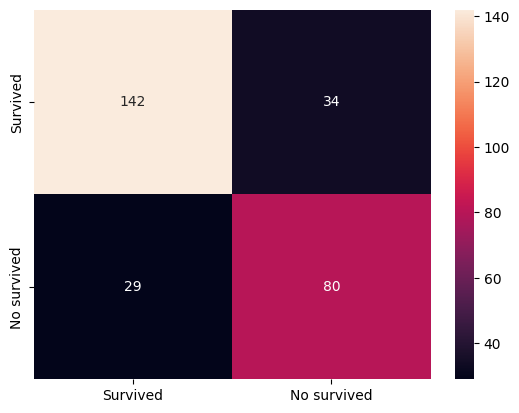

In [38]:
# Nearest Neighboors Classifier model

# On initalise le modèle : 
neighbors_classif = KNeighborsClassifier()

# On l'entraîne sur nos données d'entraînement :
neighbors_classif.fit(feat_train, target_train)

# On l'utilise pour prédire sur les données de test :
predict_class = neighbors_classif.predict(feat_test)

# On calcule l'accuracy du modèle :  
acc = accuracy_score(predict_class, target_test)
print(acc)

# On ajoute des noms aux index et aux colonnes à la matrice de confusion
classes_names = ['Survived','No survived']
cm = pd.DataFrame(confusion_matrix(target_test, predict_class), 
                  columns=classes_names, index = classes_names)

# On affiche une heatmap de seaborn pour visualiser la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d')

print(classification_report(target_test, predict_class))

## GridSearch

On récupère le travail des données du premier notebook et on va utiliser le modèle de sélection GridSearch qui permet de faire la courbe de validation pour un ou plusieurs hyperparamètres et récupérer les valeurs optimales.

In [39]:
# On va effectuer un GridSearch sur un Knn classifieur en recherchant la valeur optimale pour le nombre de voisin et 
# le leaf size

k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range, leaf_size=k_range)

In [40]:
# defining parameter range
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(feat_train, target_train)

Fitting 5 folds for each of 2401 candidates, totalling 12005 fits


In [41]:
# On récupère la valeur optimale pour le nombre de voisins et leaf size

kopti =grid_search.best_params_['n_neighbors']
leafopti = grid_search.best_params_['leaf_size']
kopti, leafopti

(32, 1)

In [42]:
#On calcule l'accuracy pour pour l'échantillon de test 
grid_search.score(feat_test, target_test)

0.7684210526315789

En comparant les deux valeurs que l'on a pour le classifieur Knn (sans et avec optimisation), il ressort que l'accuracy de la prédiction est meilleure quand on optimise le modèle.  
Il ne faut pas oublier qu'avec le GridSearch on n'a optimisé que deux de l'ensemble des hyperparamètres du modèle.

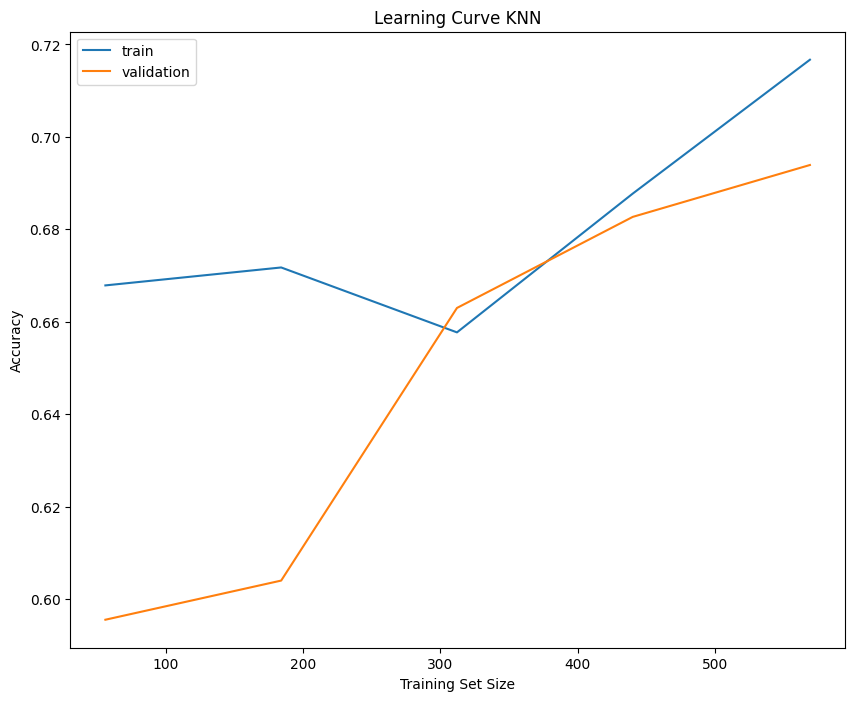

In [43]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=KNeighborsClassifier(n_neighbors=kopti, leaf_size=leafopti),
    X=features,
    y=target,
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve KNN")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.show()

## Pipeline

Le pipeline permet d'automatiser un ensemble d'étapes que l'on effectue sur le dataframe ou sur le modèle que l'on souhaite utiliser.  
Par exemple, le travail de transformer les valeurs textuelles pour la colonne "Sex" du dataframe en valeur numérique on va utiliser un encodeur pour le faire.

In [44]:
# On repars du dataframe initial
titanic_df_pipe=titanic_df.dropna()

# On sépare les features du target :
features2 = titanic_df_pipe.loc[:, ['Pclass','Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch' ]]
target2 = titanic_df_pipe["Survived"]

# On split notre dataframe en 2 :
feat_train2, feat_test2, target_train2, target_test2 = train_test_split(features2, target2, test_size = 0.4)

In [45]:
# On crée pour notre pipeline une étape de préprocesseur 

# Pour les colonnes ayant des valeurs numériques on va les standardiser avec le StandarScaler
# Il est possible, avec le GridSearch, trouver la meilleure fonction de standardisation.
num_data=['Age', 'Fare', 'SibSp', 'Parch']
num_transformer = StandardScaler()

# Pour les colonnes qui ne sont pas remplies de nombre, on utilise OneHotEncoder pour les transformer en valeurs numériques
# et pour éviter de  hiérarchiser ces valeurs numériques.
cat_data=['Sex', 'Embarked', 'Pclass']
cat_transformer=OneHotEncoder(handle_unknown='ignore')

# En effectuant le préporcesseur on va garder les colonnes initiales grâce à remainder='passthrough' 
# mais il est possible de les supprimer et changant le passthrough en drop.
preprocessor=ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_data),
        ('cat', cat_transformer, cat_data)
    ],
    remainder='passthrough'
)

In [46]:
# Création de pipeline pour plusieurs modèles

# Logistic regression
pipeline_lr=Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())]
)

# Knn
pipeline_knn=Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]
)

# SVM linear
pipeline_svm=Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', SVC())]
)

#Decision tree
pipeline_decit=Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())]
)

# Random Forest
pipeline_randof=Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())]
)

In [47]:
pipelines=[pipeline_lr, pipeline_knn, pipeline_svm, pipeline_decit, pipeline_randof]

pip_dict={
            0: 'Logistic Regression', 
            1: 'Nearest Neighbors', 
            2: 'SVM linear', 
            3: 'Decision tree',
            4: 'Random tree'            
        }

In [48]:
# On effectue le fit pour l'ensemble des pipelines
for pipe in pipelines :
    pipe.fit(feat_train2, target_train2)

In [49]:
# On teste l'accuracy pour la prédiction du jeu de données de test
for i,model in enumerate(pipelines) :
    print(f'{pip_dict[i]} Prediction accuracy {model.score(feat_test2,target_test2)}')

Logistic Regression Prediction accuracy 0.7432432432432432
Nearest Neighbors Prediction accuracy 0.7432432432432432
SVM linear Prediction accuracy 0.7297297297297297
Decision tree Prediction accuracy 0.8243243243243243
Random tree Prediction accuracy 0.7432432432432432


On va effectuer un GridSearch pour chaque pipeline afin de récuper les valeurs optimales pour les hyperparamètres 
que l'on va tester.

In [50]:
# Choix des hyperparamètres que l'on va faire varier
 
param_range_C = [0.1, 1, 10, 100, 1000]
param_range= [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

param_grid_lr = [{'classifier__penalty': ['l1', 'l2'],
                   'classifier__C': param_range_C,
                   'classifier__solver': ['liblinear']}]

param_grid_knn = [{'classifier__n_neighbors': [1, 7, 18, 30, 45, 59],
                   'classifier__weights': ['uniform', 'distance'],
                   'classifier__metric': ['euclidean', 'manhattan']}]
                   
param_grid_svm = [{'classifier__kernel': ['linear', 'rbf'], 
                    'classifier__C': param_range_C}]

param_grid_decit = [{'classifier__criterion': ['gini', 'entropy'],
                   'classifier__min_samples_leaf': param_range,
                   'classifier__max_depth': param_range,
                   'classifier__min_samples_split': param_range[1:]}]

param_grid_randof = [{'classifier__min_samples_leaf': param_range,
                   'classifier__max_depth': param_range,
                   'classifier__min_samples_split': param_range[1:]}]


In [51]:
# Création des GridSearch avec en estimator le pipeline

grid_search_lr = GridSearchCV(estimator=pipeline_lr,
        param_grid=param_grid_lr,
        scoring='accuracy',
        cv=5)
grid_search_knn = GridSearchCV(estimator=pipeline_knn,
        param_grid=param_grid_knn,
        scoring='accuracy',
        cv=5)
grid_search_svm = GridSearchCV(estimator=pipeline_svm,
        param_grid=param_grid_svm,
        scoring='accuracy',
        cv=5)
grid_search_decit = GridSearchCV(estimator=pipeline_decit,
        param_grid=param_grid_decit,
        scoring='accuracy',
        cv=5)
grid_search_randof = GridSearchCV(estimator=pipeline_randof,
        param_grid=param_grid_randof,
        scoring='accuracy',
        cv=5)

In [52]:
# On lance le fit pour chaque GridSearch
grids = [grid_search_lr, grid_search_knn, grid_search_svm, grid_search_decit, grid_search_randof]
for pipe in grids:
    pipe.fit(feat_train2,target_train2)

In [54]:
grid_dict = {
                0: 'Logistic Regression', 
                1: 'Nearest Neighbors', 
                2: 'SVM linear', 
                3: 'Decision tree',
                4: 'Random tree'
            }

# Pour chaque modèle on affiche les hyperparamètres optimaux et l'accuray pour la prédiction des données de test
# for i, model in enumerate(grids):
#     print('{} Test Accuracy: {}'.format(grid_dict[i],
#     model.score(feat_test,target_test)))
#     print('{} Best Params: {}'.format(grid_dict[i],
#     model.best_params_))

best_accuracy=0.0
best_param=''
best_classifier=''

# On récupère le meilleur modèle avec ses hyperparamètres optimaux et l'accuracy pour la prédiction des données de test
for i,model in enumerate(grids):
    if model.score(feat_test2, target_test2)>best_accuracy:
        best_accuracy=model.score(feat_test2, target_test2)
        best_param=model.best_params_
        best_classifier=i
print('Classifier with best accuracy:{}'.format(grid_dict[best_classifier]))
print('{} Best Parameters : {}'.format(grid_dict[best_classifier], best_param))
print('{} accuracy : {}'.format(grid_dict[best_classifier], best_accuracy))

Classifier with best accuracy:Decision tree
Decision tree Best Parameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2}
Decision tree accuracy : 0.7837837837837838
